In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Étape 1 : Chargement des données ---

# On charge le fichier
df = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month')

# Vérification
print("Aperçu des données :")
print(df.head())

print("\nTypes des colonnes (remplacement de info) :")
print(df.dtypes) 

Aperçu des données :
            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121

Types des colonnes (remplacement de info) :
#Passengers    int64
dtype: object


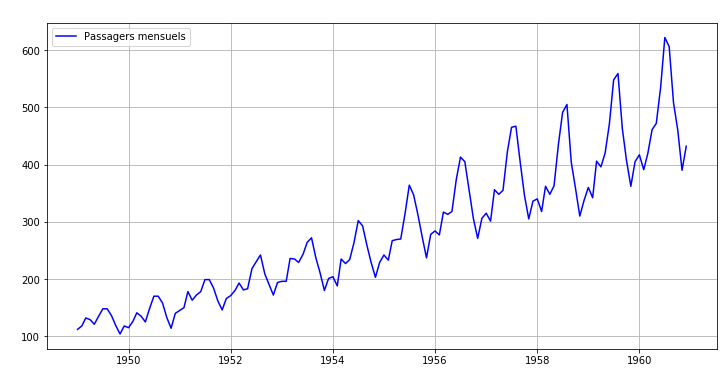

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# --- Étape 2 : Visualisation ---
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['#Passengers'], label='Passagers mensuels', color='blue')
plt.title('Historique des passagers aériens (1949-1960)',color='white')
plt.xlabel('Année',color='white')
plt.ylabel('Nombre de passagers',color='white')
plt.legend()
plt.grid(True)
plt.show()

--- Vue Annuelle (5 premières lignes) ---
            #Passengers
Month                  
1949-12-31   126.666667
1950-12-31   139.666667
1951-12-31   170.166667
1952-12-31   197.000000
1953-12-31   225.000000

--- Données décalées de 5 mois ---
            #Passengers
Month                  
1949-01-01          NaN
1949-02-01          NaN
1949-03-01          NaN
1949-04-01          NaN
1949-05-01          NaN
1949-06-01        112.0
1949-07-01        118.0


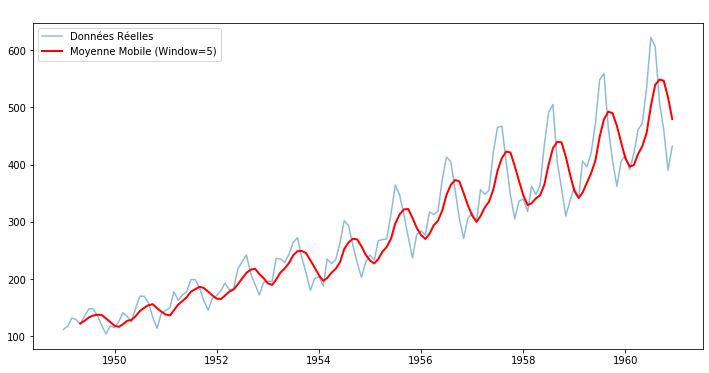


--- Mois avec moins de 120 passagers ---
            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-10-01          119
1949-11-01          104
1949-12-01          118
1950-01-01          115
1950-11-01          114


In [65]:
# --- Étape 3 : Opérations sur la série temporelle ---

# 1. Rééchantillonnage (Vue annuelle moyenne)
df_yearly = df.resample('A').mean() 
print("--- Vue Annuelle (5 premières lignes) ---")
print(df_yearly.head())

# 2. Déplacement (Shift de 5 mois)
df_shifted = df.shift(5)
print("\n--- Données décalées de 5 mois ---")
print(df_shifted.head(7))

# 3. Windowing (Lissage avec fenêtre de 5)
df_rolling = df.rolling(window=5).mean()

# Visualisation du lissage
plt.figure(figsize=(12, 6))
plt.plot(df['#Passengers'], label='Données Réelles', alpha=0.5)
plt.plot(df_rolling['#Passengers'], label='Moyenne Mobile (Window=5)', color='red', linewidth=2)
plt.title('Comparaison : Réel vs Lissé (Windowing)',color='white')
plt.legend()
plt.show()

# 4. Sélection des dates où passagers < 120
low_traffic = df[df['#Passengers'] < 120]
print("\n--- Mois avec moins de 120 passagers ---")
print(low_traffic)

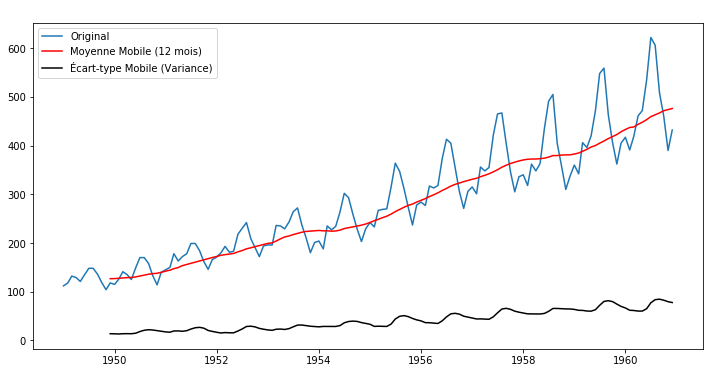

--- Résultats du Test Dickey-Fuller ---
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
dtype: float64

CONCLUSION : La p-value > 0.05. La série n'est PAS stationnaire (elle a une tendance/saisonnalité).


In [66]:
# --- Étape 4 : Vérification de la stationnarité ---

# 1. & 2. Courbes Moyenne et Variance (Ecart-type) Mobiles
# On prend une fenêtre de 12 (1 an) pour voir la tendance annuelle
rolmean = df.rolling(window=12).mean()
rolstd = df.rolling(window=12).std()

plt.figure(figsize=(12, 6))
plt.plot(df, label='Original')
plt.plot(rolmean, label='Moyenne Mobile (12 mois)', color='red')
plt.plot(rolstd, label='Écart-type Mobile (Variance)', color='black')
plt.title('Test visuel de stationnarité (Moyenne & Variance mobiles)',color='white')
plt.legend()
plt.show()

# 3. Test ADF (Dickey-Fuller)
print("--- Résultats du Test Dickey-Fuller ---")
dftest = adfuller(df['#Passengers'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print(dfoutput)

if dfoutput['p-value'] > 0.05:
    print("\nCONCLUSION : La p-value > 0.05. La série n'est PAS stationnaire (elle a une tendance/saisonnalité).")
else:
    print("\nCONCLUSION : La série est stationnaire.")

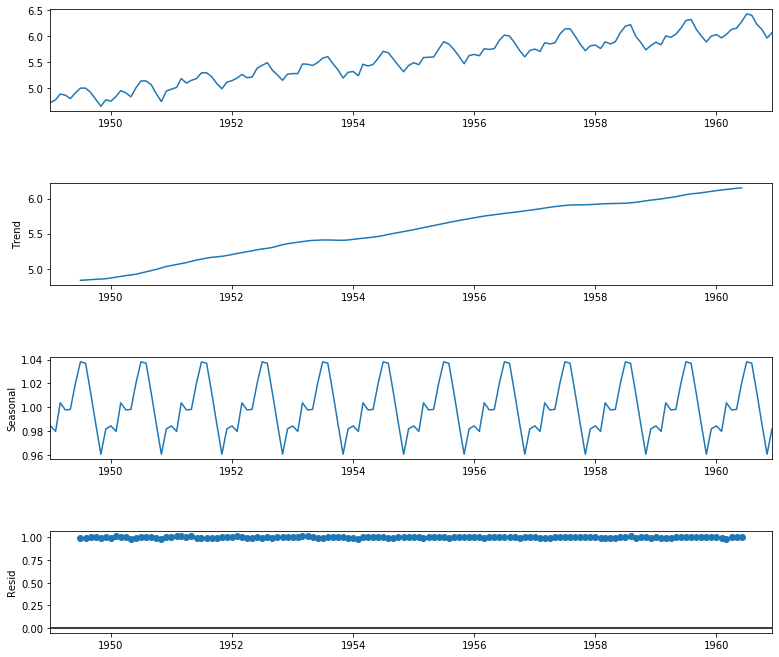

In [68]:
# --- Étape 5 : Rendre la série stationnaire ---

# 1. & 2. Transformation Logarithmique + Différenciation
# Le Log stabilise la variance (réduit l'écart des vagues)
df_log = np.log(df)
# La Différenciation stabilise la moyenne (enlève la tendance montante)
df_log_diff = df_log - df_log.shift(1)
df_log_diff.dropna(inplace=True)

# 3. Décomposition STL (Saisonnalité, Tendance, Résidu)
decomposition = seasonal_decompose(df_log, model='multiplicative')

# Visualisation des composants
fig = decomposition.plot()
fig.set_size_inches(12, 10)
plt.show()

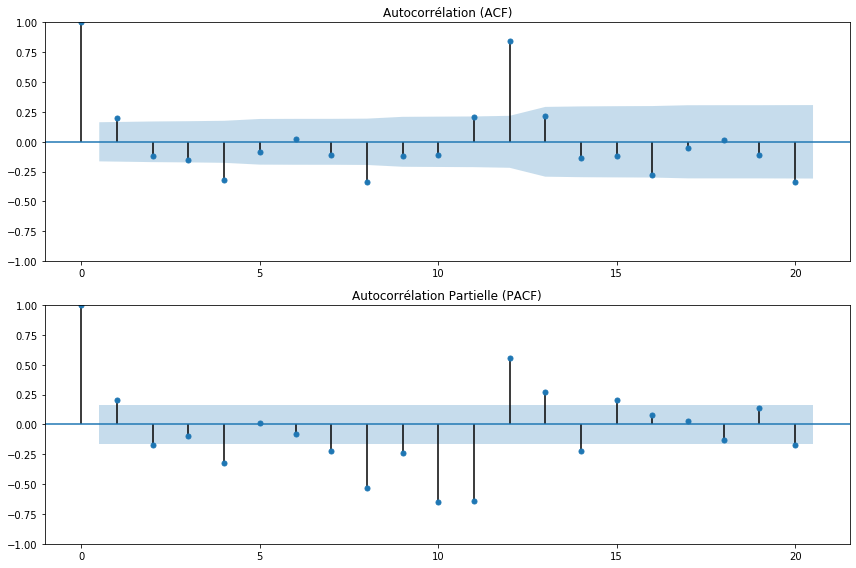

In [69]:
# --- Étape 6 : Autocorrélation ---

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF : Aide à déterminer q (Moyenne mobile)
plot_acf(df_log_diff, ax=ax1, lags=20, title='Autocorrélation (ACF)')

# PACF : Aide à déterminer p (Partie AutoRegressive)
plot_pacf(df_log_diff, ax=ax2, lags=20, title='Autocorrélation Partielle (PACF)')

plt.tight_layout()
plt.show()

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  132
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 114.050
Date:                Sun, 14 Dec 2025   AIC                           -222.099
Time:                        11:30:37   BIC                           -213.473
Sample:                    01-01-1949   HQIC                          -218.594
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6043      0.160     -3.771      0.000      -0.918      -0.290
ma.L1          0.8680      0.089      9.709      0.000       0.693       1.043
sigma2         0.0102      0.002      5.765      0.0

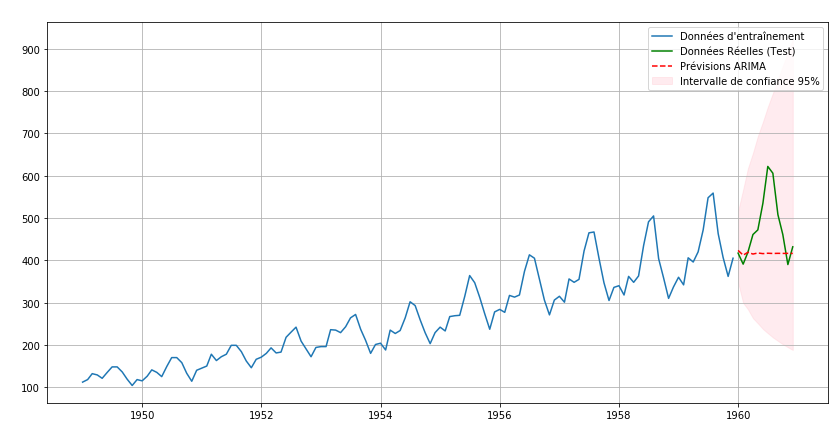

In [71]:
# --- Étape 7 : Modélisation ---
# On sépare les données : Entraînement (Tout sauf les 12 derniers mois) et Test (Les 12 derniers mois)
train_data = df_log[:-12]
test_data = df_log[-12:]

# Création du modèle ARIMA
model = ARIMA(train_data, order=(1, 1, 1)) 
model_fit = model.fit()

print(model_fit.summary())
# --- Étape 8 : Prévisions ---

# Prévisions sur 12 mois
forecast_result = model_fit.get_forecast(steps=12)
forecast_log = forecast_result.predicted_mean
conf_int_log = forecast_result.conf_int()

# Conversion inverse (exponentielle) pour revenir aux vrais nombres de passagers
forecast_val = np.exp(forecast_log)
test_data_val = np.exp(test_data)
train_data_val = np.exp(train_data)
lower_limits = np.exp(conf_int_log.iloc[:, 0])
upper_limits = np.exp(conf_int_log.iloc[:, 1])

# Visualisation finale
plt.figure(figsize=(14, 7))
plt.plot(train_data_val.index, train_data_val['#Passengers'], label='Données d\'entraînement')
plt.plot(test_data_val.index, test_data_val['#Passengers'], label='Données Réelles (Test)', color='green')
plt.plot(forecast_val.index, forecast_val, label='Prévisions ARIMA', color='red', linestyle='--')
plt.fill_between(forecast_val.index, lower_limits, upper_limits, color='pink', alpha=0.3, label='Intervalle de confiance 95%')

plt.title('Prévisions vs Réalité (12 derniers mois)', color='white')
plt.xlabel('Date', color='white')
plt.ylabel('Nombre de passagers', color='white')
plt.legend()
plt.grid(True)
plt.show()


--- Comparaison : Amélioration du modèle ---


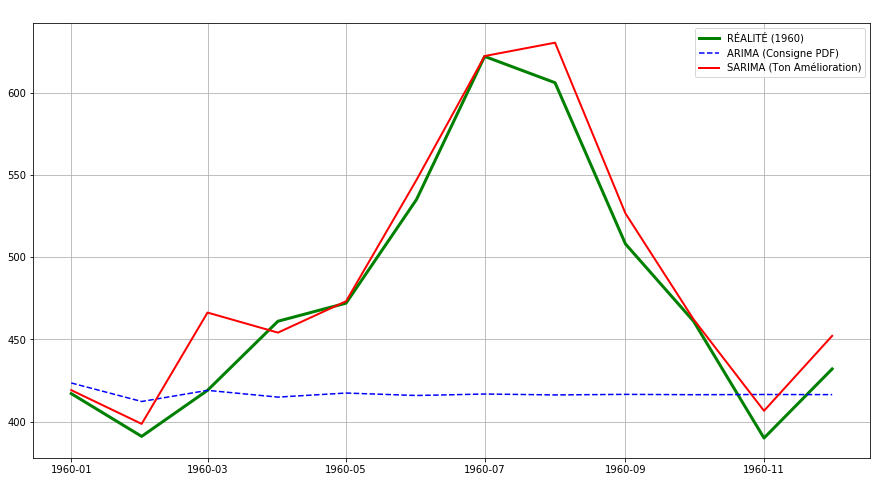

In [72]:
# --- ÉTAPE 9 (Bonus): Amélioration avec SARIMA ---
import statsmodels.api as sm
import matplotlib.pyplot as plt

print("--- Comparaison : Amélioration du modèle ---")

# Par sécurité, on s'assure que les données sont bien chargées
train_data = df_log[:-12]

# 1. On entraîne le modèle SARIMA avec des paramètres "Box-Jenkins" très stables
model_sarima = sm.tsa.statespace.SARIMAX(train_data, 
                                         order=(0, 1, 1), 
                                         seasonal_order=(0, 1, 1, 12), 
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
model_sarima_fit = model_sarima.fit(disp=False)

# 2. Prévisions SARIMA
forecast_sarima_log = model_sarima_fit.get_forecast(steps=12).predicted_mean
forecast_sarima_val = np.exp(forecast_sarima_log) # Retour à l'échelle normale

# 3. GRAPHIQUE DE COMPARAISON FINALE
plt.figure(figsize=(15, 8))

# Données réelles (Vert)
plt.plot(test_data_val.index, test_data_val['#Passengers'], label='RÉALITÉ (1960)', color='green', linewidth=3)

if 'forecast_val' not in locals():
    forecast_val = np.exp(model_fit.get_forecast(steps=12).predicted_mean)
plt.plot(forecast_val.index, forecast_val, label='ARIMA (Consigne PDF)', color='blue', linestyle='--')

plt.plot(forecast_sarima_val.index, forecast_sarima_val, label='SARIMA (Ton Amélioration)', color='red', linewidth=2)

plt.title('Preuve d\'amélioration : ARIMA vs SARIMA',color='white')
plt.legend()
plt.grid(True)
plt.show()

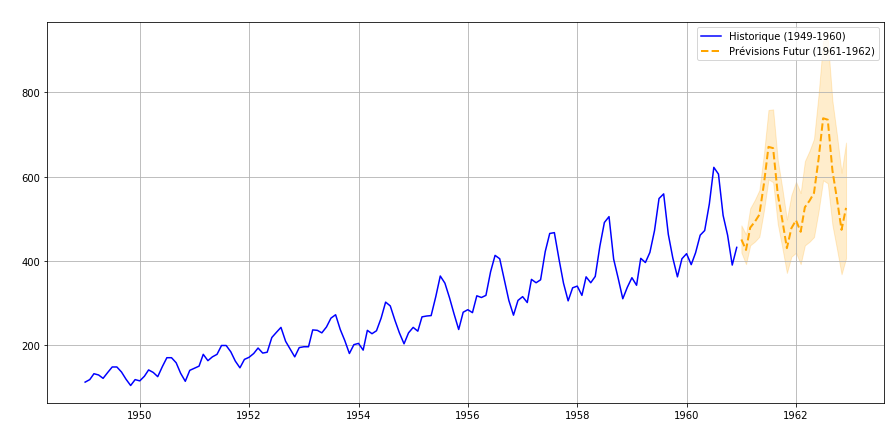

In [74]:
# --- ÉTAPE 10 ( Bonus) : Prédiction du Futur (1961-1962) ---

# On réentraîne le modèle stable sur TOUTES les données
full_model = sm.tsa.statespace.SARIMAX(df_log, 
                                       order=(0, 1, 1), 
                                       seasonal_order=(0, 1, 1, 12),
                                       enforce_stationarity=False,
                                       enforce_invertibility=False)
full_fit = full_model.fit(disp=False)

# On prédit 24 mois dans le futur
future_forecast = full_fit.get_forecast(steps=24)
future_vals = np.exp(future_forecast.predicted_mean)
future_conf = np.exp(future_forecast.conf_int())

# Graphique Final
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['#Passengers'], label='Historique (1949-1960)', color='blue')
plt.plot(future_vals.index, future_vals, label='Prévisions Futur (1961-1962)', color='orange', linewidth=2, linestyle='--')
plt.fill_between(future_vals.index, future_conf.iloc[:, 0], future_conf.iloc[:, 1], color='orange', alpha=0.2)

plt.title('Projection Stratégique : Prévisions pour 1961-1962',color='white')
plt.xlabel('Année',color='white')
plt.ylabel('Nombre de passagers',color='white')
plt.legend()
plt.grid(True)
plt.show()
